In [1]:
from devito import *
from examples.seismic.source import WaveletSource, TimeAxis
from examples.seismic import plot_image
import numpy as np

from sympy import init_printing, latex
init_printing(use_latex=True)

In [2]:
# Initial grid: 1km x 1km, with spacing 100m
extent = (2000., 2000.)
shape = (81, 81)
x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=extent[0]/(shape[0]-1)))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', value=extent[1]/(shape[1]-1)))
grid = Grid(extent=extent, shape=shape, dimensions=(x, z))

src_coords(p_src, d) None (0, 0)
src_coords(p_src, d) {p_src: left, d: left} <function generic_derivative at 0x7f7faacf1378>


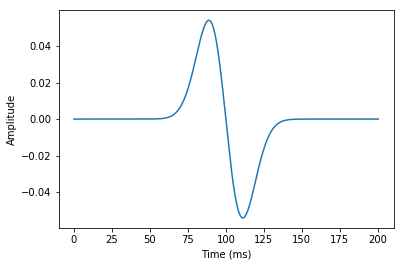

In [3]:
class DGaussSource(WaveletSource):
    
    def wavelet(self, f0, t):
        a = 0.004
        return -2.*a*(t - 1./f0) * np.exp(-a * (t - 1./f0)**2)

# Timestep size from Eq. 7 with V_p=6000. and dx=100
t0, tn = 0., 200.
dt = 1e2*(1. / np.sqrt(2.)) / 60.
time_range = TimeAxis(start=t0, stop=tn, step=dt)

src = DGaussSource(name='src', grid=grid, f0=0.01, time_range=time_range)
src.coordinates.data[:] = [1000., 1000.]
src.show()

In [4]:
# Now we create the velocity and pressure fields
p = TimeFunction(name='p', grid=grid, staggered='node', space_order=2, time_order=1)
vx= TimeFunction(name='vx', grid=grid, staggered=x, space_order=2, time_order=1)
vz = TimeFunction(name='vz', grid=grid, staggered=z, space_order=2, time_order=1)

p(t, x, z) node (0, 0, 0)
p(t, x, z) {t: left, x: left, z: left} <function staggered_diff at 0x7f7faacf1510>
vx(t, x, z) x (0, 1, 0)
vx(t, x, z) {t: left, x: right, z: left} <function staggered_diff at 0x7f7faacf1510>
vz(t, x, z) z (0, 0, 1)
vz(t, x, z) {t: left, x: left, z: right} <function staggered_diff at 0x7f7faacf1510>


In [5]:
t = grid.stepping_dim
time = grid.time_dim

# We need some initial conditions
V_p = 4.0
#V_s = 1.0
density = 3.

dx = 100.
rox = 1/density * dt
roz = 1/density * dt
l2m = V_p*V_p*density * dt

c1 = 9.0/8.0;
c2 = -1.0/24.0;

# The source injection term
src_p = src.inject(field=p.forward, expr=src)

# 2nd order acoustic according to fdelmoc
u_vx_2 = Eq(vx.forward, vx + rox * p.dx)
u_vz_2 = Eq(vz.forward, vz + roz * p.dz)
u_p_2 = Eq(p.forward, p + l2m * (vx.forward.dx + vz.forward.dz))

op_2 = Operator([u_vx_2, u_vz_2, u_p_2] + src_p)


# 4th order acoustic according to fdelmoc
# Now we create the velocity and pressure fields
p4 = TimeFunction(name='p', grid=grid, staggered='node',space_order=4, time_order=1)
vx4= TimeFunction(name='vx', grid=grid, staggered=x, space_order=4, time_order=1)
vz4 = TimeFunction(name='vz', grid=grid, staggered=z, space_order=4, time_order=1)
u_vx_2 = Eq(vx4.forward, vx4 + rox * p4.dx)
u_vz_2 = Eq(vz4.forward, vz4 + roz * p4.dz)
u_p_2 = Eq(p4.forward, p4 + l2m * (vx4.forward.dx + vz4.forward.dz))

op_4 = Operator([u_vx_2, u_vz_2, u_p_2] + src_p)

p(t, x, z) node (0, 0, 0)
p(t, x, z) {t: left, x: left, z: left} <function staggered_diff at 0x7f7faacf1510>
vx(t, x, z) x (0, 1, 0)
vx(t, x, z) {t: left, x: right, z: left} <function staggered_diff at 0x7f7faacf1510>
vz(t, x, z) z (0, 0, 1)
vz(t, x, z) {t: left, x: left, z: right} <function staggered_diff at 0x7f7faacf1510>


GNUCompiler: cache hit `/tmp/devito-jitcache-uid944902/9ee7f6a1206614afdd88aef667c7d8c02367a24d.c` [0.01 s]
section0<171,81,81> with OI=0.77 computed in 0.003 s [8.29 GFlops/s, 1.31 GPts/s]
section1<<171,1>,<171,1>,<171,1>,<171,1>> with OI=7.75 computed in 0.000 s [2.36 GFlops/s, 0.08 GPts/s]


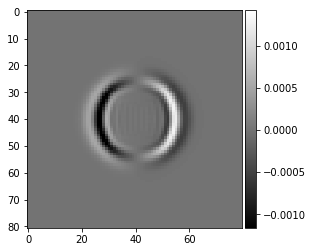

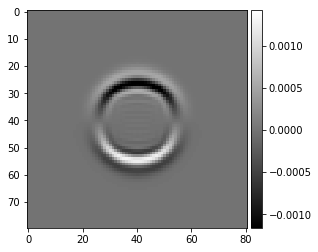

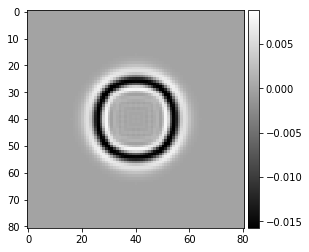

In [6]:
### 2nd order acoustic

# Reset the fields
vx.data[:] = 0.
vz.data[:] = 0.
p.data[:] = 0.


op_2(time=src.time_range.num-1)

# Let's see what we got....
plot_image(vx.data[0])
plot_image(vz.data[0])
plot_image(p.data[0])

GNUCompiler: compiled `/tmp/devito-jitcache-uid944902/bc7fd9ab16acbc177bb9bc819bebad2609532519.c` [0.19 s]
section0<<171,81,81>,<171,81,81>> with OI=1.58 computed in 0.002 s [19.65 GFlops/s, 1.51 GPts/s]
section1<<171,1>,<171,1>,<171,1>,<171,1>> with OI=7.75 computed in 0.000 s [3.03 GFlops/s, 0.10 GPts/s]


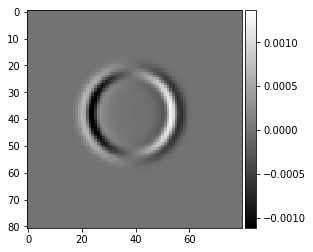

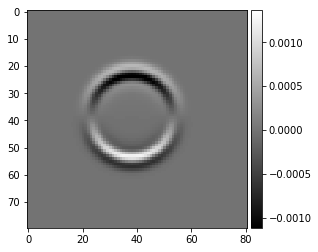

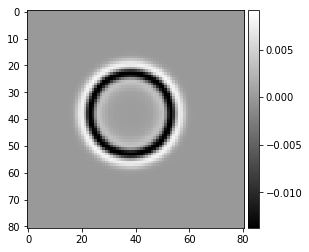

In [7]:
### 4th order acoustic


op_4(time=src.time_range.num-1)

# Let's see what we got....
plot_image(vx4.data[0])
plot_image(vz4.data[0])
plot_image(p4.data[0])